# SELFormer Model

This notebook demonstrates the use of a pretrained foundation model, SELFormer, to generate embeddings based on a molecules SELFie annotations and predict (binary classification) sufficient potency. A molecule is deemed potent if pIC50 >8.

In [81]:
#creating deepcopy of model instances
from copy import deepcopy

#Python standard libraries
from pathlib import Path
from warnings import filterwarnings
import time
import pandas as pd
import numpy as np
import pickle

#helper packages
# from .utils.helpers import performance_measures, model_performance, \
#  model_training_and_validation, get_splits

#XGBoost library
import xgboost as xgb

#visualization
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap

import ast
import torch

#sklearn models and metric functions
from sklearn import metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score,roc_curve,\
      precision_score, f1_score,roc_auc_score, confusion_matrix

#Silence some expected warnings
filterwarnings("ignore")

#Fix seed for reproducible results
SEED = 22
torch.manual_seed(SEED)

In [51]:
#import train and test datasets with pretrained and finetuned embeddings 
train_pre = pd.read_csv("../models/SELFormer/data/EGFR_train_valid_embeddings.csv")
train_ft = pd.read_csv("../models/SELFormer/data/EGFR_train_valid_embeddings_ft.csv")
test_pre = pd.read_csv("../models/SELFormer/data/EGFR_test_embeddings.csv")
test_ft = pd.read_csv("../models/SELFormer/data/EGFR_test_embeddings_ft.csv")

In [52]:

#convert sequence embeddings to floats
train_pre['sequence_embeddings'] = train_pre['sequence_embeddings'].apply(ast.literal_eval)
train_ft['sequence_embeddings'] = train_ft['sequence_embeddings'].apply(ast.literal_eval)
test_pre['sequence_embeddings'] = test_pre['sequence_embeddings'].apply(ast.literal_eval)
test_ft['sequence_embeddings'] = test_ft['sequence_embeddings'].apply(ast.literal_eval)

In [6]:
train_pre.head()

,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,label,sequence_embeddings
0,8.747147,522.168141,10,5,1.70260,True,1,"[1.2085514068603516, -0.11604826897382736, -0...."
1,4.525347,344.142219,2,0,4.23280,True,0,"[1.3283782005310059, 0.05607220157980919, -0.3..."
2,6.000000,438.086160,7,2,5.03420,True,0,"[1.0904375314712524, -0.017458688467741013, -0..."
3,8.795880,499.269573,8,2,4.50980,True,1,"[1.0145310163497925, -0.1012229472398758, -0.3..."
4,5.508638,271.030314,5,2,2.94918,True,0,"[1.0852192640304565, 0.22207874059677124, -0.2..."


In [26]:
def get_splits(df):
    """
    Helper function to split the dataset into train and validation datasets

    Parameters
    ----------
    df: pandas df object
        The dataframe to split into train, test sets.

    Returns
    -------
    list:
        list with train_x, test_x, train_y, test_y dataframes.
    """
    fingerprint_to_model = train_pre.sequence_embeddings.tolist()
    label_to_model = train_pre.label.tolist()

    # Split data randomly in train and test set
    # note that we use test/train_x for the respective fingerprint splits
    # and test/train_y for the respective label splits
    (
        static_train_x,
        static_test_x,
        static_train_y,
        static_test_y,
    ) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
    splits = [static_train_x, static_test_x, static_train_y, static_test_y]
    
    print("Training data size:", len(static_train_x))
    print("Test data size:", len(static_test_x))

    return splits

In [27]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [28]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

## Training models on embeddings

#### Random Forest

In [29]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [30]:
#training splits from pretrained trained model 
splits_pre = get_splits(train_pre)
#training splits from finetuned model 
splits_ft = get_splits(train_ft)


Training data size: 2966
Test data size: 742
Training data size: 2966
Test data size: 742


In [31]:
# Fit model on pretrained model embeddings
performance_measures = model_training_and_validation(model_RF, "RF", splits_pre)

Sensitivity: 0.20
Specificity: 0.97
AUC: 0.80


In [32]:
# Fit model on finetuned model embeddings
performance_measures = model_training_and_validation(model_RF, "RF", splits_ft)

Sensitivity: 0.23
Specificity: 0.98
AUC: 0.81


#### XGBoost

In [34]:
#best performing xgboost model
file_name = "../models/XGBoost/checkpoints/xgb_best.pkl"

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))


In [35]:
# Fit model on pretrained model embeddings
performance_measures = model_training_and_validation(xgb_model_loaded, "xgboost", splits_pre)

Sensitivity: 0.36
Specificity: 0.96
AUC: 0.82


In [36]:
# Fit model on finetuned model embeddings
performance_measures = model_training_and_validation(xgb_model_loaded, "xgboost", splits_ft)

Sensitivity: 0.36
Specificity: 0.96
AUC: 0.82


## Predictions on Finetuned Selformer

The predictions of the finetuned SELFormer model have been generated using command line code predict the labels ofthe test set. Below is an evaluation of the model's performance.

In [6]:
#read in predictions
selformer_finetuned_predictions = pd.read_csv("../models/SELFormer/data/predictions/EGFR_finetuned_predictions.csv")

In [7]:
selformer_finetuned_predictions.head()

,selfies,label,prediction
0,[O][C][=C][C][=N][C][=N][C][Branch1][=N][N][C]...,1,1
1,[N][C][=C][C][=C][Branch2][Ring1][=N][N][C][NH...,1,0
2,[N][#C][C][Branch1][Ring1][C][#N][=C][C][=C][C...,0,0
3,[C][C][=C][C][=C][Branch2][Ring2][#Branch1][C]...,0,0
4,[C][O][C][=C][C][Branch1][N][/C][=C][Branch1][...,0,0


In [11]:
# Performance of model on test set
accuracy = accuracy_score(selformer_finetuned_predictions['label'], selformer_finetuned_predictions['prediction'])
sens = precision_score(selformer_finetuned_predictions['label'], selformer_finetuned_predictions['prediction'])
spec = recall_score(selformer_finetuned_predictions['label'], selformer_finetuned_predictions['prediction'], pos_label=0)
auc = roc_auc_score(selformer_finetuned_predictions['label'], selformer_finetuned_predictions['prediction'])

# Print performance results
print(f"Accuracy: {accuracy:.2}")
print(f"Sensitivity: {sens:.2f}")
print(f"Specificity: {spec:.2f}")
print(f"AUC: {auc:.2f}")

Accuracy: 0.84
Sensitivity: 0.57
Specificity: 0.91
AUC: 0.73


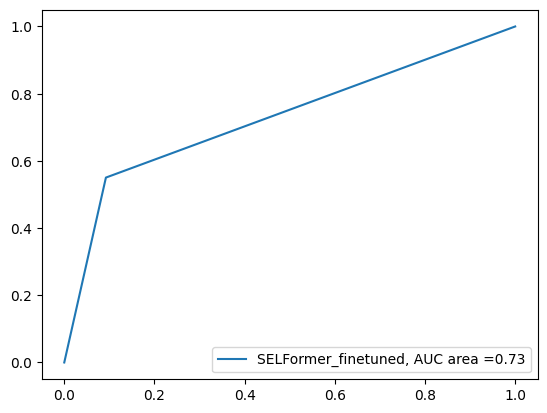

In [16]:
fpr, tpr, _ = metrics.roc_curve(selformer_finetuned_predictions['label'], selformer_finetuned_predictions['prediction'])
auc = metrics.roc_auc_score(selformer_finetuned_predictions['label'], selformer_finetuned_predictions['prediction'])
plt.plot(fpr,tpr,label=(f"SELFormer_finetuned, AUC area ={auc:.2f}"))
plt.legend(loc=4)
plt.show()

## Visualising Embeddings

In [53]:
train_pre["sequence_embeddings"]

0       [1.2085514068603516, -0.11604826897382736, -0....
1       [1.3283782005310059, 0.05607220157980919, -0.3...
2       [1.0904375314712524, -0.017458688467741013, -0...
3       [1.0145310163497925, -0.1012229472398758, -0.3...
4       [1.0852192640304565, 0.22207874059677124, -0.2...
                              ...                        
3703    [1.205885887145996, 0.034735020250082016, -0.4...
3704    [1.2105857133865356, -0.02618359588086605, -0....
3705    [1.0500062704086304, 0.14164292812347412, -0.4...
3706    [1.0916906595230103, 0.10151149332523346, -0.5...
3707    [1.2008588314056396, -0.050559353083372116, -0...
Name: sequence_embeddings, Length: 3708, dtype: object

In [78]:
#convert to numpy arrayrs
embeddings_pre = test_pre["sequence_embeddings"].to_numpy()
embeddings_ft = test_ft["sequence_embeddings"].to_numpy()
embeddings_pre=np.array([np.array(xi) for xi in embeddings_pre])
embeddings_ft=np.array([np.array(xi) for xi in embeddings_ft])

In [82]:
#convert to umap embeddings
umap_embeddings_pre = umap.UMAP().fit(embeddings_pre)
umap_embeddings_ft = umap.UMAP().fit(embeddings_ft)

In [83]:
import umap.plot

Text(0.5, 1.0, 'Finetuned SELFormer Embeddings')

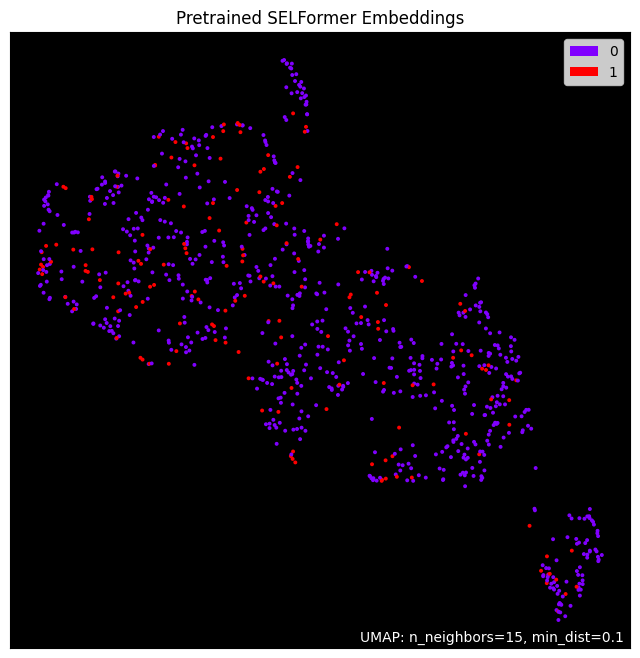

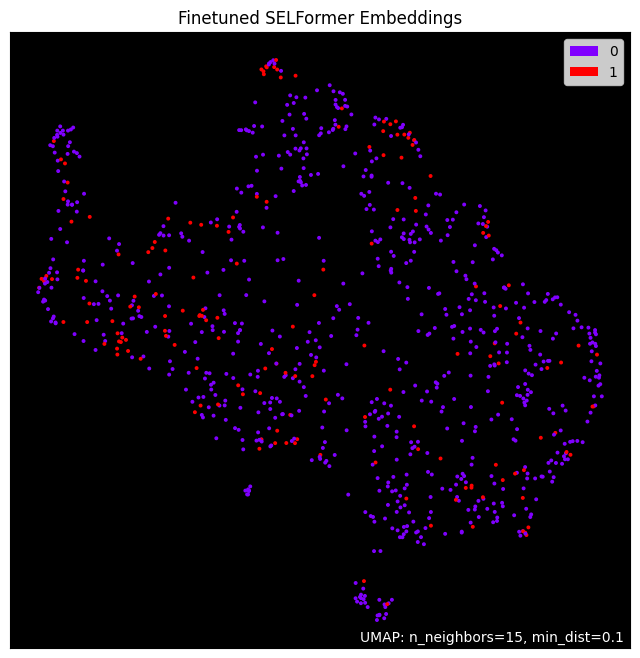

In [87]:
#plot embeddings of predicted test labels for pretrained and finetuned foundation models
umap_pre = umap.plot.points(umap_embeddings_pre, labels=test_pre.label,theme='fire')
umap_pre.set_title("Pretrained SELFormer Embeddings")
umap_ft = umap.plot.points(umap_embeddings_ft, labels=test_ft.label,theme='fire')
umap_ft.set_title("Finetuned SELFormer Embeddings")